---
title: 3D NIGnets Showcase
subtitle: Fitting shapes using 3D NIGnets
date: 2025-03-08
---

We now fit 3D NIGnets to some target shapes to get a sense of their representation power and
shortcomings.

In [4]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs
from NIGnets import NIGnet
from NIGnets.monotonic_nets import SmoothMinMaxNet

from assets.utils import automate_training, plot_surfaces

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

We will use the following network architecture for PreAux nets in this showcase. Users need to
define their own PreAux net architectures similarly making sure that the conditions on the output
are met [](#preaux_net_conditions).

In [3]:
class PreAuxNet(nn.Module):
    def __init__(self, layer_count, hidden_dim):
        super().__init__()

        # Pre-Auxilliary net needs closed transform to get same r at theta = 0, 2pi
        self.closed_transform = lambda t, s: torch.hstack([
            torch.sin(torch.pi * s) * torch.cos(2 * torch.pi * t),
            torch.sin(torch.pi * s) * torch.sin(2 * torch.pi * t),
            torch.cos(torch.pi * s)
        ])

        layers = [nn.Linear(3, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.PReLU()]
        for i in range(layer_count):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.PReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.ReLU())

        self.forward_stack = nn.Sequential(*layers)
    
    def forward(self, t, s):
        unit_sphere = self.closed_transform(t, s)

        r = self.forward_stack(unit_sphere)
        X = r * unit_sphere
        return X

## Sphere and Cube

Epoch: [   1/1000]. Loss:    1.505007
Epoch: [ 200/1000]. Loss:    0.000960
Epoch: [ 400/1000]. Loss:    0.000690
Epoch: [ 600/1000]. Loss:    0.002493
Epoch: [ 800/1000]. Loss:    0.000633
Epoch: [1000/1000]. Loss:    0.000622


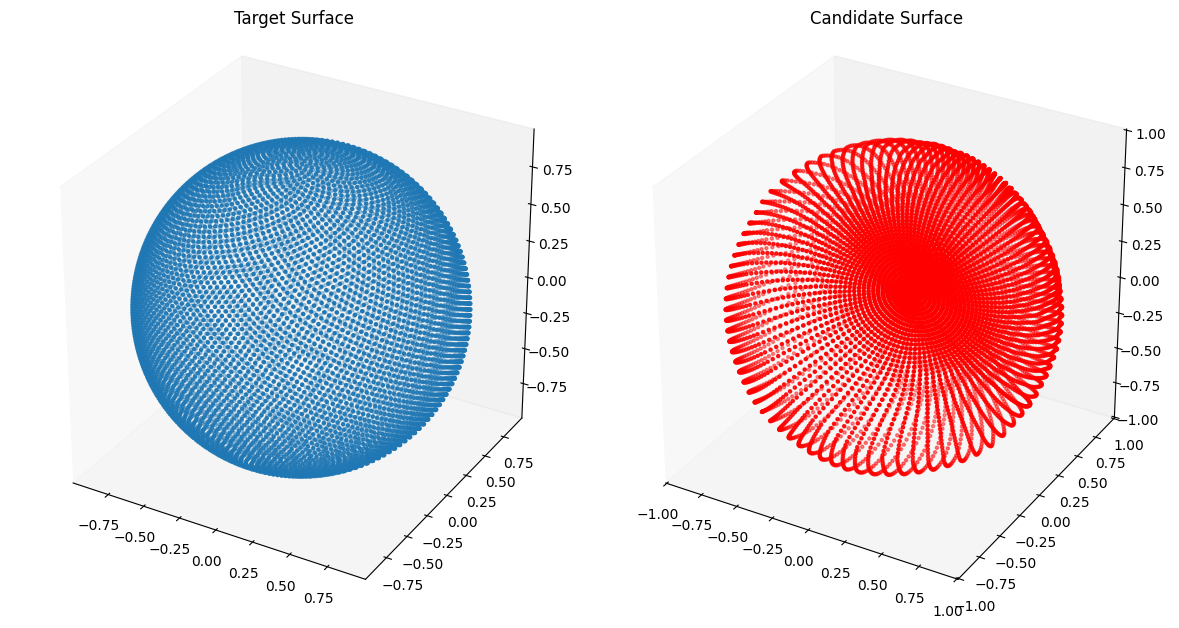

In [12]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 3, nodes_per_group = 3)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Epoch: [   1/1000]. Loss:    2.127341
Epoch: [ 200/1000]. Loss:    0.004418
Epoch: [ 400/1000]. Loss:    0.002507
Epoch: [ 600/1000]. Loss:    0.001962
Epoch: [ 800/1000]. Loss:    0.001924
Epoch: [1000/1000]. Loss:    0.002003


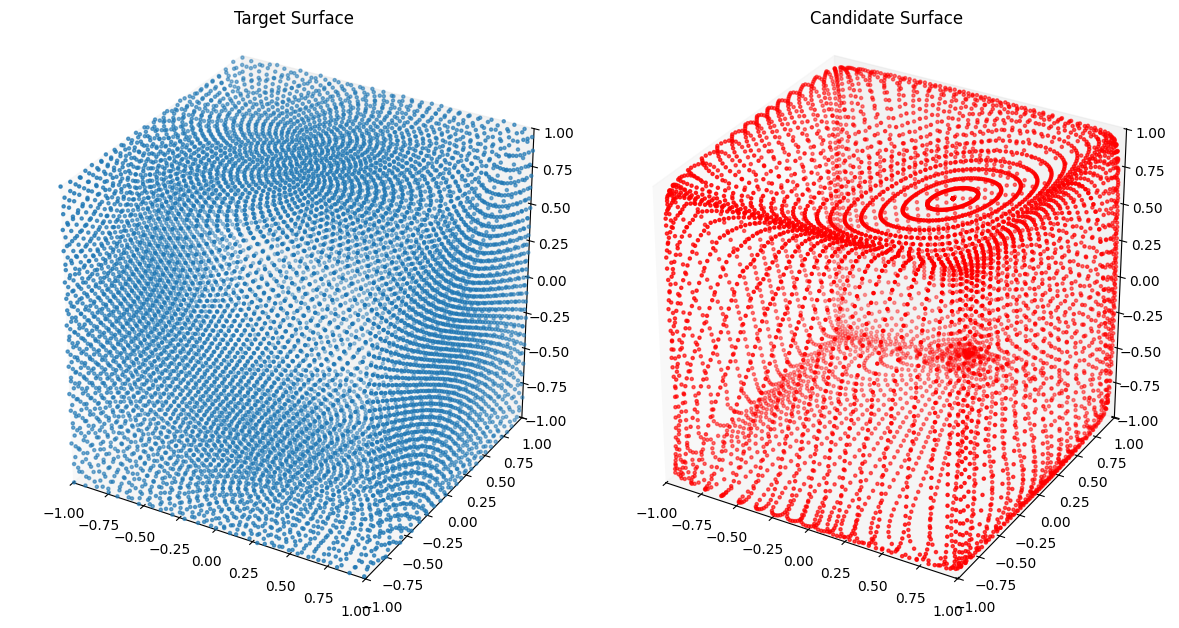

In [17]:
from assets.shapes import cube

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = cube(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 5, nodes_per_group = 5)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)